# 1. Connect kaggle API and get data

# Swin Transformers

In [1]:
!pip install tensorflow-addons==0.23.0

In [2]:
# !pip install -U tensorflow-addons

## 2.1. Setup

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## 2.2. Normalization
**Với:**
- XY1 defocused_blur
- XY2 motion_blur
- XY3 noise
- XY4 rain

### 2.2.2. Load prepared data

In [4]:
# Đọc dữ liệu từ tập tin .npz
loaded_data_train = np.load('/kaggle/input/preprocessed-data/training_data.npz')
loaded_data_test = np.load('/kaggle/input/preprocessed-data/testing_data.npz')

# Truy cập mảng từ dữ liệu đã đọc
x_train = loaded_data_train['x_train']
y_train = loaded_data_train['y_train']
x_test = loaded_data_test['x_test']
y_test = loaded_data_test['y_test']

# Giảm giá trị của nhãn đi 1 để bắt đầu từ 0
y_train = y_train - 1
y_test = y_test - 1

# In thông báo sau khi tải thành công
print("Dữ liệu đã được tải thành công.")

# Kiểm tra kích thước của dữ liệu
print(f'x_train shape: {x_train.shape} - y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} - y_test shape: {y_test.shape}')


Dữ liệu đã được tải thành công.
x_train shape: (17582, 128, 128, 3) - y_train shape: (17582,)
x_test shape: (7537, 128, 128, 3) - y_test shape: (7537,)


In [5]:
# Đếm số lượng mẫu cho mỗi nhóm label trong tập train
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_label_counts = dict(zip(unique_train, counts_train))
print("Train Label Counts:", train_label_counts)

# Đếm số lượng mẫu cho mỗi nhóm label trong tập test
unique_test, counts_test = np.unique(y_test, return_counts=True)
test_label_counts = dict(zip(unique_test, counts_test))
print("Test Label Counts:", test_label_counts)

Train Label Counts: {0: 734, 1: 5039, 2: 2212, 3: 9597}
Test Label Counts: {0: 315, 1: 2160, 2: 948, 3: 4114}


In [6]:
num_classes = 4

input_shape = (128, 128, 3)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
# Define label names
# label_names = ["defocused_blur", "motion_blur", "noise", "rain"]

# Display a sample of images with labels and names
# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)

#     # Display label name
#     label_index = np.argmax(y_train[i])
#     # label_name = label_names[label_index]
#     plt.title(label_index)

#     # Display the image
#     plt.imshow(x_train[i])

# plt.show()

x_train shape: (17582, 128, 128, 3) - y_train shape: (17582, 4)
x_test shape: (7537, 128, 128, 3) - y_test shape: (7537, 4)


## 2.4. Setup tham số

In [7]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 128  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 30 #40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

## 2.5. Định nghĩa hàm

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

In [9]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x

@register_keras_serializable()
class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [10]:
@register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


In [11]:
@register_keras_serializable()
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## 2.6. Model training and evaluation


### 2.6.1. Extract and embed patches

In [12]:
@register_keras_serializable()
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


@register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


@register_keras_serializable()
class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### 2.6.2. Build the model

In [13]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

### 2.6.3. Training

In [14]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/30
124/124 [==============================] - 122s 950ms/step - loss: 1.0686 - accuracy: 0.6539 - top-5-accuracy: 1.0000 - val_loss: 0.7435 - val_accuracy: 0.8209 - val_top-5-accuracy: 1.0000
Epoch 2/30
124/124 [==============================] - 118s 953ms/step - loss: 0.7711 - accuracy: 0.7955 - top-5-accuracy: 1.0000 - val_loss: 0.5502 - val_accuracy: 0.9125 - val_top-5-accuracy: 1.0000
Epoch 3/30
124/124 [==============================] - 118s 954ms/step - loss: 0.6637 - accuracy: 0.8553 - top-5-accuracy: 1.0000 - val_loss: 0.4493 - val_accuracy: 0.9795 - val_top-5-accuracy: 1.0000
Epoch 4/30
124/124 [==============================] - 118s 955ms/step - loss: 0.6158 - accuracy: 0.8771 - top-5-accuracy: 1.0000 - val_loss: 0.4239 - val_accuracy: 0.9932 - val_top-5-accuracy: 1.0000
Epoch 5/30
124/124 [==============================] - 118s 955ms/step - loss: 0.5836 - accuracy: 0.8947 - top-5-accuracy: 1.0000 - val_loss: 0.4342 - val_accuracy: 0.9852 - val_top-5-accuracy: 1.0000


### 2.6.4. Validation
Let's visualize the training progress of the model.

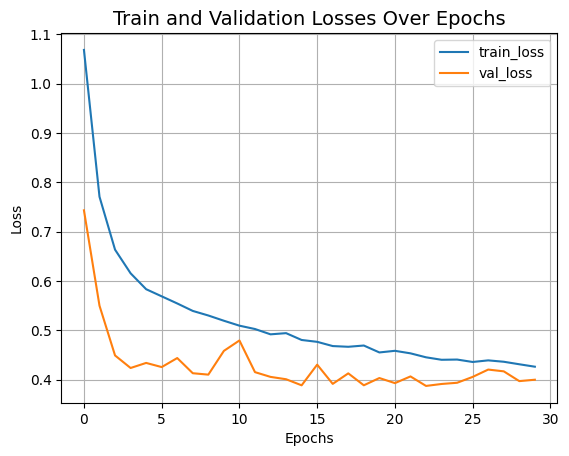

In [15]:
# Điều chỉnh code vẽ đồ thị
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

# Tạo mảng chứa vị trí của các điểm trên trục x
xticks_positions = np.arange(0, num_epochs + 1, 5)

# Đặt các đường kẻ dọc tại các vị trí xticks
plt.xticks(xticks_positions)

# Hiển thị lưới
plt.grid()

plt.show()

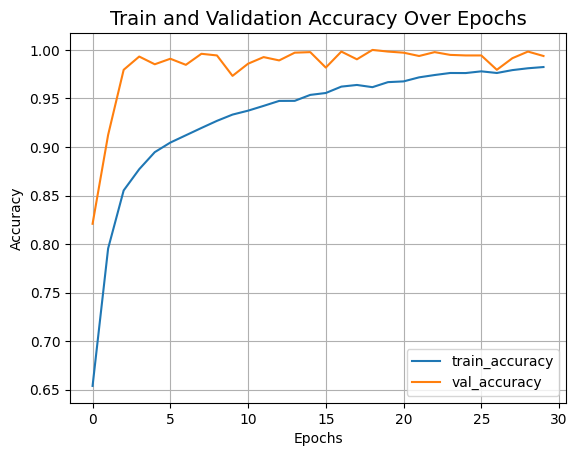

In [16]:
# Điều chỉnh code vẽ đồ thị
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

# Tạo mảng chứa vị trí của các điểm trên trục x
xticks_positions = np.arange(0, num_epochs + 1, 5)

# Đặt các đường kẻ dọc tại các vị trí xticks
plt.xticks(xticks_positions)

# Hiển thị lưới
plt.grid()

plt.show()

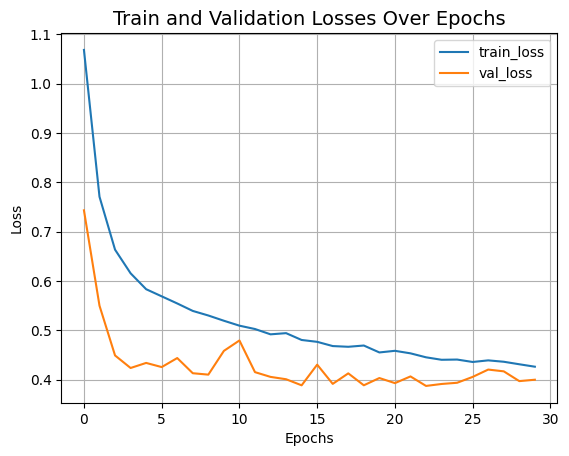

In [17]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Display the final results of the training

In [18]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

236/236 [==============================] - 17s 72ms/step - loss: 0.4879 - accuracy: 0.9488 - top-5-accuracy: 1.0000
Test loss: 0.49
Test accuracy: 94.88%
Test top 5 accuracy: 100.0%


In [19]:
import keras
# !mkdir /kaggle/working/pre-train
model.save('/kaggle/working/swin_model_weights.keras')

In [20]:
# # It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model('/kaggle/working/swin_model_weights.keras')

# # # Let's check:
# # np.testing.assert_allclose(
# #     model.predict(test_input), reconstructed_model.predict(test_input)
# # )

# loss, accuracy, top_5_accuracy = reconstructed_model.evaluate(x_test, y_test)
# print(f"Test loss: {round(loss, 2)}")
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

## 2.7. Trial

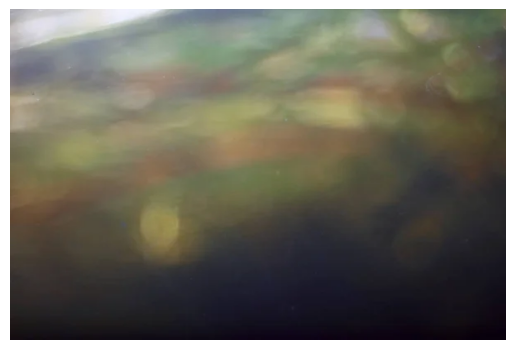

1/1 [==============================] - 1s 775ms/step
Predicted Label: Noise


In [21]:
image_path = "/kaggle/input/trial-images/trial_images/defocus_blur/011.jpg"

# Đọc ảnh bằng OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang dạng RGB

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tắt các trục
plt.show()

img = cv2.resize(img, (128, 128))  # Chuẩn hóa kích thước
img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]
# Mở rộng chiều cho ảnh để phù hợp với đầu vào của mô hình
img = np.expand_dims(img, axis=0)

# Sử dụng mô hình để phân loại
predictions = model.predict(img)
# Lấy nhãn của lớp có xác suất cao nhất
predicted_label = np.argmax(predictions)

# In kết quả
if predicted_label == 0:
    print("Predicted Label: Defocused blur")
elif predicted_label == 1:
    print("Predicted Label: Motion blur")
elif predicted_label == 2:
    print("Predicted Label: Noise")
elif predicted_label == 3:
    print("Predicted Label: Rain")
else:
    print("Unknown label")

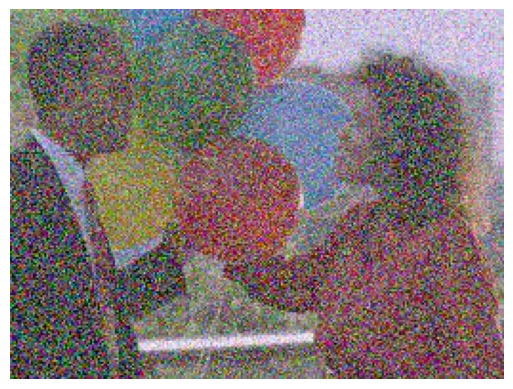

1/1 [==============================] - 0s 35ms/step
Predicted Label: Noise


In [22]:
image_path = "/kaggle/input/trial-images/trial_images/noise/007.jpg"

# Đọc ảnh bằng OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang dạng RGB

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tắt các trục
plt.show()

img = cv2.resize(img, (128, 128))  # Chuẩn hóa kích thước
img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]
# Mở rộng chiều cho ảnh để phù hợp với đầu vào của mô hình
img = np.expand_dims(img, axis=0)

# Sử dụng mô hình để phân loại
predictions = model.predict(img)
# Lấy nhãn của lớp có xác suất cao nhất
predicted_label = np.argmax(predictions)

# In kết quả
if predicted_label == 0:
    print("Predicted Label: Defocused blur")
elif predicted_label == 1:
    print("Predicted Label: Motion blur")
elif predicted_label == 2:
    print("Predicted Label: Noise")
elif predicted_label == 3:
    print("Predicted Label: Rain")
else:
    print("Unknown label")

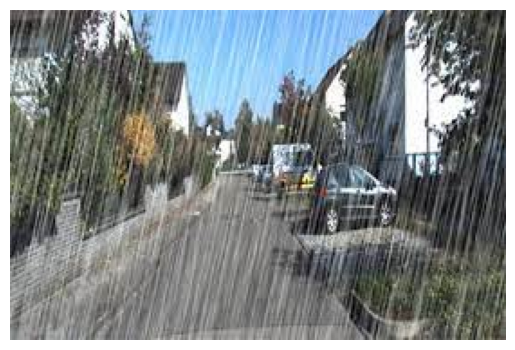

1/1 [==============================] - 0s 26ms/step
Predicted Label: Rain


In [23]:
image_path = "/kaggle/input/trial-images/trial_images/rain/005.jpg"

# Đọc ảnh bằng OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang dạng RGB

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tắt các trục
plt.show()

img = cv2.resize(img, (128, 128))  # Chuẩn hóa kích thước
img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]
# Mở rộng chiều cho ảnh để phù hợp với đầu vào của mô hình
img = np.expand_dims(img, axis=0)

# Sử dụng mô hình để phân loại
predictions = model.predict(img)
# Lấy nhãn của lớp có xác suất cao nhất
predicted_label = np.argmax(predictions)

# In kết quả
if predicted_label == 0:
    print("Predicted Label: Defocused blur")
elif predicted_label == 1:
    print("Predicted Label: Motion blur")
elif predicted_label == 2:
    print("Predicted Label: Noise")
elif predicted_label == 3:
    print("Predicted Label: Rain")
else:
    print("Unknown label")

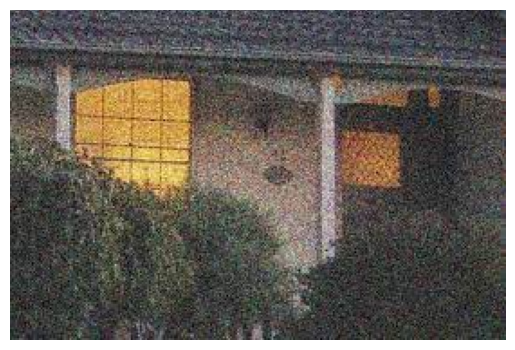

1/1 [==============================] - 0s 26ms/step
Predicted Label: Rain


In [24]:
image_path = "/kaggle/input/trial-images/trial_images/noise/009.jpg"

# Đọc ảnh bằng OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang dạng RGB

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tắt các trục
plt.show()

img = cv2.resize(img, (128, 128))  # Chuẩn hóa kích thước
img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]
# Mở rộng chiều cho ảnh để phù hợp với đầu vào của mô hình
img = np.expand_dims(img, axis=0)

# Sử dụng mô hình để phân loại
predictions = model.predict(img)
# Lấy nhãn của lớp có xác suất cao nhất
predicted_label = np.argmax(predictions)

# In kết quả
if predicted_label == 0:
    print("Predicted Label: Defocused blur")
elif predicted_label == 1:
    print("Predicted Label: Motion blur")
elif predicted_label == 2:
    print("Predicted Label: Noise")
elif predicted_label == 3:
    print("Predicted Label: Rain")
else:
    print("Unknown label")